# 🛠️ Baseline Evaluation: (s,S) Policy

Evaluate the (s,S) baseline policy using the simulation engine.

**Goal**: Establish baseline metrics for RL agent comparison

In [1]:
import sys

sys.path.insert(0, "..")

import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

from src.seeds import generate_seeds

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

## Generate SEEDS

In [2]:
BASELINE_SEEDS = generate_seeds(5)  # First 5 seeds from pool
print("🎲 Baseline Evaluation Seeds:")
print(f"   {BASELINE_SEEDS}")

🎲 Baseline Evaluation Seeds:
   [6145, 4098, 6148, 2055, 4103]


## Part 1: Import (s,S) Policy

In [3]:
from src.baseline import sSPolicy ,create_sS_policy
from src.mdp import sample_initial_state

# Policy parameters (from empirical notebook calculations)
policy = create_sS_policy((20, 38), (19, 37))
print(policy)

# Quick test with first baseline seed
test_rng = np.random.default_rng(BASELINE_SEEDS[0])
test_state = sample_initial_state(steady_state=(11, 13), rng=test_rng)
action = policy(test_state)
print(
    f"\nTest (seed={BASELINE_SEEDS[0]}): IP=({test_state.get_inventory_position(0)}, {test_state.get_inventory_position(1)})"
)
print(f"  → Order: {action.order_quantities}")

(s,S) Policy: P0=(s_min=20, s_max=38), P1=(s_min=19, s_max=37)

Test (seed=6145): IP=(13, 12)
  → Order: (25, 25)


## Part 2: Simple Simulation Test

In [4]:
from src.simulation import InventorySimulation
from src.mdp import RewardFunction

demo_seed = BASELINE_SEEDS[0]
demo_rng = np.random.default_rng(demo_seed)

sim = InventorySimulation(random_state=demo_rng)
reward_fn = RewardFunction()

initial_state = sample_initial_state(rng=demo_rng)
sim.reset(initial_state)

print("=" * 60)
print(f"SIMULATION: One Trimester (100 days) - Seed: {demo_seed}")
print("=" * 60)

DAYS = 100

total_cost = 0
for day in range(DAYS):
    state = sim.get_current_state()
    action = policy(state)
    new_state, _ = sim.execute_daily_decision(action)

    costs = reward_fn.calculate_costs(new_state, action)
    total_cost += costs.total_cost

    if day < 5 or day >= DAYS - 5:  # Show first/last 5 days
        print(
            f"Day {day+1:2d}: IP=({state.get_inventory_position(0):3d}, {state.get_inventory_position(1):3d}) "
            f"→ Order {action.order_quantities} → Cost ${costs.total_cost:.2f}"
        )

# Get statistics from built-in logger
all_stats = sim.logger.get_all_statistics()
total_customers = sum(s.num_customers for s in all_stats)
total_demand_0 = sum(s.total_demand_per_product.get(0, 0) for s in all_stats)
total_demand_1 = sum(s.total_demand_per_product.get(1, 0) for s in all_stats)

print(f"\n{'='*60}")
print(f"Total Cost: ${total_cost:.2f} | Avg Daily: ${total_cost/DAYS:.2f}")
print(f"Customers: {total_customers} | Demand: ({total_demand_0}, {total_demand_1})")

SIMULATION: One Trimester (100 days) - Seed: 6145
Day  1: IP=( 13,  12) → Order (25, 25) → Cost $195.00
Day  2: IP=( 38,  37) → Order (0, 0) → Cost $25.00
Day  3: IP=( 38,  37) → Order (0, 0) → Cost $25.00
Day  4: IP=( 38,  37) → Order (0, 0) → Cost $20.00
Day  5: IP=( 37,  33) → Order (0, 0) → Cost $20.00
Day 96: IP=( 32,  35) → Order (0, 0) → Cost $29.00
Day 97: IP=( 32,  35) → Order (0, 0) → Cost $29.00
Day 98: IP=( 32,  35) → Order (0, 0) → Cost $29.00
Day 99: IP=( 32,  35) → Order (0, 0) → Cost $29.00
Day 100: IP=( 32,  35) → Order (0, 0) → Cost $29.00

Total Cost: $4041.00 | Avg Daily: $40.41
Customers: 28 | Demand: (66, 101)


### Visualize Inventory Evolution (from Logger)

/var/folders/rj/6cfjbftj3tgcdt_v_3n95t_r0000gn/T/ipykernel_70304/3370076918.py:31: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rj/6cfjbftj3tgcdt_v_3n95t_r0000gn/T/ipykernel_70304/3370076918.py:31: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/marin/Documents/UNIMORE_4^anno/RL-InventorySystem/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/marin/Documents/UNIMORE_4^anno/RL-InventorySystem/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


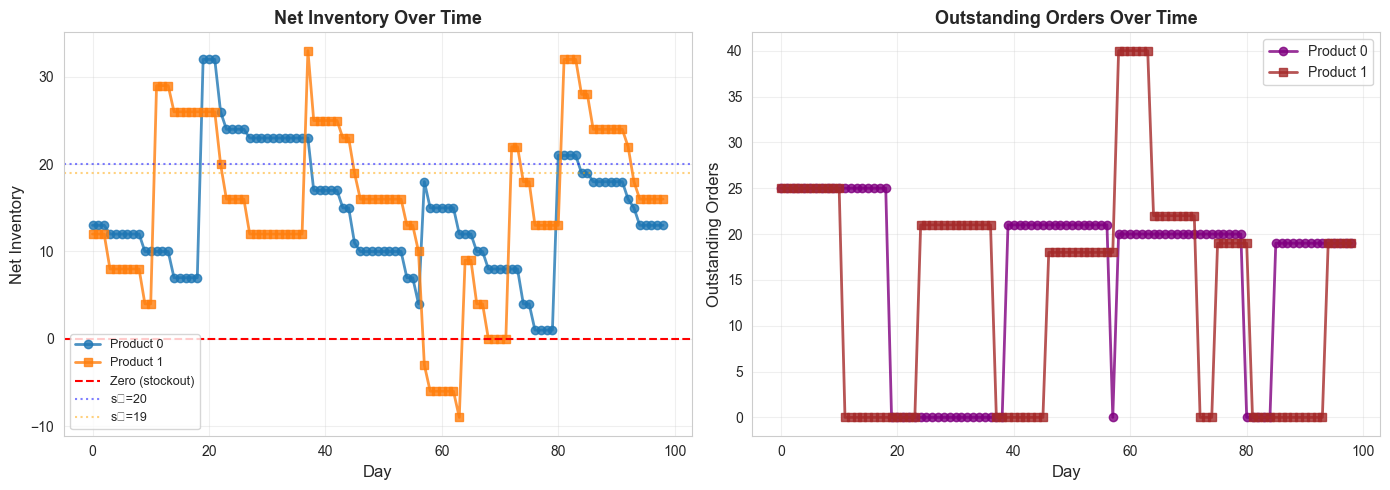

In [5]:
# Visualize using logger data (no manual tracking needed!)
days = [s.day for s in all_stats]
net_inv_0 = [s.net_inventory_per_product.get(0, 0) for s in all_stats]
net_inv_1 = [s.net_inventory_per_product.get(1, 0) for s in all_stats]
outstanding_0 = [s.outstanding_per_product.get(0, 0) for s in all_stats]
outstanding_1 = [s.outstanding_per_product.get(1, 0) for s in all_stats]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Net inventory
axes[0].plot(days, net_inv_0, marker='o', linewidth=2, label='Product 0', alpha=0.8)
axes[0].plot(days, net_inv_1, marker='s', linewidth=2, label='Product 1', alpha=0.8)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero (stockout)')
axes[0].axhline(policy.get_s_min(0), color='blue', linestyle=':', alpha=0.5, label=f's₀={policy.get_s_min(0)}')
axes[0].axhline(policy.get_s_min(1), color='orange', linestyle=':', alpha=0.5, label=f's₁={policy.get_s_min(1)}')
axes[0].set_xlabel('Day', fontsize=12)
axes[0].set_ylabel('Net Inventory', fontsize=12)
axes[0].set_title('Net Inventory Over Time', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Outstanding orders
axes[1].plot(days, outstanding_0, marker='o', linewidth=2, label='Product 0', color='purple', alpha=0.8)
axes[1].plot(days, outstanding_1, marker='s', linewidth=2, label='Product 1', color='brown', alpha=0.8)
axes[1].set_xlabel('Day', fontsize=12)
axes[1].set_ylabel('Outstanding Orders', fontsize=12)
axes[1].set_title('Outstanding Orders Over Time', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: Full Evaluation (100 Episodes)

In [6]:
NUM_EPISODES = 100  # years
DAYS_PER_EPISODE = 365

# Use all baseline seeds for robust evaluation (repeat 20 times per seed)
print(f"📊 Evaluation Configuration:")
print(f"   Seeds: {len(BASELINE_SEEDS)} different seeds")
print(f"   Episodes per seed: {NUM_EPISODES // len(BASELINE_SEEDS)} years")
print(f"   Total episodes: {NUM_EPISODES} years")
print(f"   Days per episode: {DAYS_PER_EPISODE}")

📊 Evaluation Configuration:
   Seeds: 5 different seeds
   Episodes per seed: 20 years
   Total episodes: 100 years
   Days per episode: 365


In [7]:

def evaluate_policy(policy: sSPolicy, num_episodes: int, days_per_episode: int, seeds: List[int]):
    """
    Evaluate policy over multiple episodes with proper seed management.

    Args:
        policy: The (s,S) policy to evaluate
        num_episodes: Number of episodes (years) to run
        days_per_episode: Days per episode (default: 365 = 1 year)
        seeds: List of seeds to use (cycles through them)

    Returns:
        Dictionary with evaluation metrics
    """
    
    reward_fn = RewardFunction()
    episode_avg_costs = []  # Average daily cost per episode
    episode_total_costs = []  # Total cost per episode

    # Statistics from logger
    total_customers = 0
    total_demand_0 = 0
    total_demand_1 = 0

    print(f"Running {num_episodes} episodes with {len(seeds)} seed(s)...")
    
    for ep in range(num_episodes):
        # Cycle through seeds (e.g., 5 seeds for 100 episodes = 20 episodes per seed)
        seed = seeds[ep % len(seeds)]
        
        # Create RNG for this episode
        episode_rng = np.random.default_rng(seed + (ep // len(seeds)))
        
        # Sample initial state for each episode
        initial_state = sample_initial_state(
            steady_state=(11, 13), randomness=5, rng=episode_rng
        )
        
        sim = InventorySimulation(random_state=episode_rng)
        sim.reset(initial_state)

        episode_cost = 0
        for _ in range(days_per_episode):
            state = sim.get_current_state()
            action = policy(state)
            new_state, _ = sim.execute_daily_decision(action)

            costs = reward_fn.calculate_costs(new_state, action)
            episode_cost += costs.total_cost

        avg_daily_cost = episode_cost / days_per_episode
        episode_avg_costs.append(avg_daily_cost)
        episode_total_costs.append(episode_cost)

        # Get statistics from logger
        stats = sim.logger.get_all_statistics()
        total_customers += sum(s.num_customers for s in stats)
        total_demand_0 += sum(s.total_demand_per_product.get(0, 0) for s in stats)
        total_demand_1 += sum(s.total_demand_per_product.get(1, 0) for s in stats)

    # Episode-level metrics (average daily cost per year)
    episode_daily_mean = np.mean(episode_avg_costs)
    episode_daily_std = np.std(episode_avg_costs)
    episode_daily_ci_95 = 1.96 * episode_daily_std / np.sqrt(len(episode_avg_costs))

    # Episode-level metrics (total cost per year)
    episode_total_mean = np.mean(episode_total_costs)
    episode_total_std = np.std(episode_total_costs)
    episode_total_ci_95 = 1.96 * episode_total_std / np.sqrt(len(episode_total_costs))

    return {
        "episode_daily_mean": episode_daily_mean,
        "episode_daily_std": episode_daily_std,
        "episode_daily_ci_95": episode_daily_ci_95,
        "episode_total_mean": episode_total_mean,
        "episode_total_std": episode_total_std,
        "episode_total_ci_95": episode_total_ci_95,
        "total_customers": total_customers,
        "total_demand_0": total_demand_0,
        "total_demand_1": total_demand_1,
        "episode_avg_costs": episode_avg_costs,
        "episode_total_costs": episode_total_costs,
        "seeds_used": seeds,
    }


print(f"✅ Evaluation function ready with proper seed management")
print(f"\nRunning baseline evaluation with {len(BASELINE_SEEDS)} seeds...")
results = evaluate_policy(
    policy, 
    num_episodes=NUM_EPISODES, 
    days_per_episode=DAYS_PER_EPISODE,
    seeds=BASELINE_SEEDS
)

print(f"\n{'='*60}")
print("RESULTS - DAILY COST METRICS")
print(f"{'='*60}")
print(f"  Mean:    ${results['episode_daily_mean']:.2f} per day")
print(f"  Std Dev: ${results['episode_daily_std']:.2f}")
print(f"  95% CI:  ±${results['episode_daily_ci_95']:.2f}")

print(f"\n{'='*60}")
print("RESULTS - YEARLY COST METRICS")
print("=" * 60)
print(f"  Mean:    ${results['episode_total_mean']:.2f} per year")
print(f"  Std Dev: ${results['episode_total_std']:.2f}")
print(f"  95% CI:  ±${results['episode_total_ci_95']:.2f}")

print(f"\n{'='*60}")
print("DEMAND STATISTICS")
print(f"{'='*60}")
print(f"  Total customers: {results['total_customers']}")
print(f"{'='*60}")
print(
    f"  Avg per episode: {results['total_customers']/NUM_EPISODES:.1f} customers, P0={results['total_demand_0']/NUM_EPISODES:.1f}, P1={results['total_demand_1']/NUM_EPISODES:.1f}"
)
print(f"  Total demand: P0={results['total_demand_0']}, P1={results['total_demand_1']}")

print(f"\n🎲 Seeds used: {results['seeds_used']}")
print(f"💡 Each seed evaluated {NUM_EPISODES // len(BASELINE_SEEDS)} times")

✅ Evaluation function ready with proper seed management

Running baseline evaluation with 5 seeds...
Running 100 episodes with 5 seed(s)...

RESULTS - DAILY COST METRICS
  Mean:    $45.09 per day
  Std Dev: $5.19
  95% CI:  ±$1.02

RESULTS - YEARLY COST METRICS
  Mean:    $16458.76 per year
  Std Dev: $1894.30
  95% CI:  ±$371.28

DEMAND STATISTICS
  Total customers: 12500
  Avg per episode: 125.0 customers, P0=313.2, P1=454.0
  Total demand: P0=31316, P1=45402

🎲 Seeds used: [6145, 4098, 6148, 2055, 4103]
💡 Each seed evaluated 20 times


## Part 4: Visualize Results

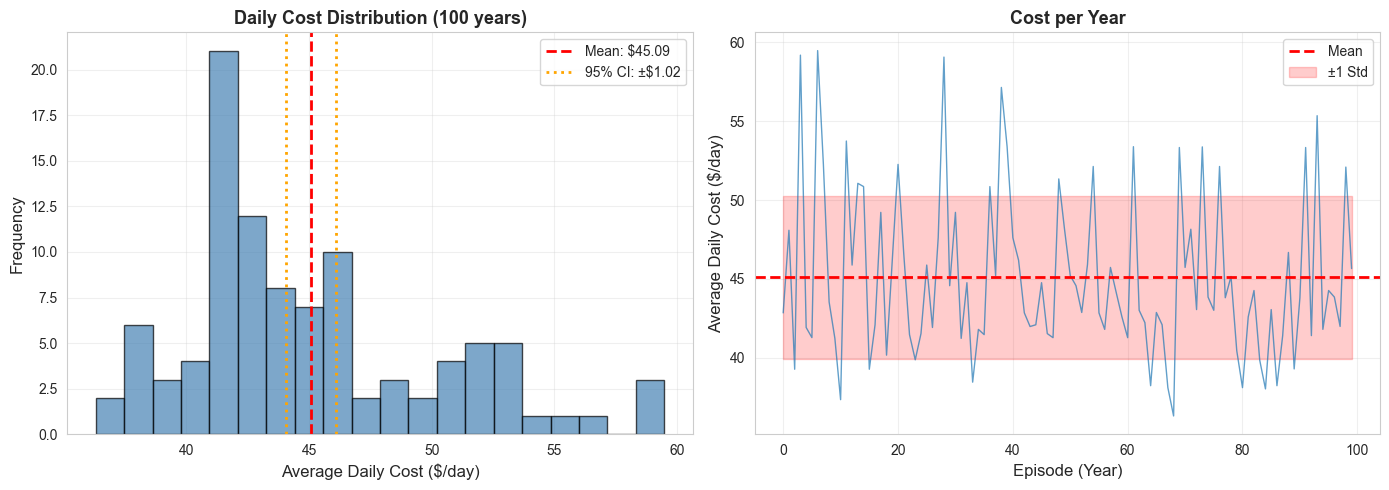

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cost distribution (average daily cost per year)
axes[0].hist(
    results["episode_avg_costs"],
    bins=20,
    edgecolor="black",
    alpha=0.7,
    color="steelblue",
)
axes[0].axvline(
    results["episode_daily_mean"],
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: ${results['episode_daily_mean']:.2f}",
)
axes[0].axvline(
    results["episode_daily_mean"] - results["episode_daily_ci_95"],
    color="orange",
    linestyle=":",
    linewidth=2,
)
axes[0].axvline(
    results["episode_daily_mean"] + results["episode_daily_ci_95"],
    color="orange",
    linestyle=":",
    linewidth=2,
    label=f"95% CI: ±${results['episode_daily_ci_95']:.2f}",
)
axes[0].set_xlabel("Average Daily Cost ($/day)", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].set_title("Daily Cost Distribution (100 years)", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Cost over episodes
axes[1].plot(results["episode_avg_costs"], alpha=0.7, linewidth=1)
axes[1].axhline(
    results["episode_daily_mean"],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Mean",
)
axes[1].fill_between(
    range(len(results["episode_avg_costs"])),
    results["episode_daily_mean"] - results["episode_daily_std"],
    results["episode_daily_mean"] + results["episode_daily_std"],
    alpha=0.2,
    color="red",
    label="±1 Std",
)
axes[1].set_xlabel("Episode (Year)", fontsize=12)
axes[1].set_ylabel("Average Daily Cost ($/day)", fontsize=12)
axes[1].set_title("Cost per Year", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 5: Save Baseline Results

In [9]:
# Create results directory
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

# Prepare data
baseline_data = {
    "policy": str(policy),
    "params": policy.params,
    "evaluation": {
        "num_episodes": NUM_EPISODES,
        "days_per_episode": DAYS_PER_EPISODE,
        "seeds_used": [int(s) for s in results["seeds_used"]],
        "episodes_per_seed": NUM_EPISODES // len(BASELINE_SEEDS),
        "daily_cost_metrics": {
            "mean": float(results["episode_daily_mean"]),
            "std": float(results["episode_daily_std"]),
            "ci_95": float(results["episode_daily_ci_95"]),
        },
        "yearly_cost_metrics": {
            "mean": float(results["episode_total_mean"]),
            "std": float(results["episode_total_std"]),
            "ci_95": float(results["episode_total_ci_95"]),
        },
        "demand_statistics": {
            "total_customers": int(results["total_customers"]),
            "total_demand_0": int(results["total_demand_0"]),
            "total_demand_1": int(results["total_demand_1"]),
            "avg_customers_per_year": float(results["total_customers"] / NUM_EPISODES),
            "avg_demand_0_per_year": float(results["total_demand_0"] / NUM_EPISODES),
            "avg_demand_1_per_year": float(results["total_demand_1"] / NUM_EPISODES),
        },
    },
    "episode_avg_costs": [float(c) for c in results["episode_avg_costs"]],
    "episode_total_costs": [float(c) for c in results["episode_total_costs"]],
    "reproducibility_note": "Use the same seeds when evaluating RL agents for fair comparison",
}


# Save
baseline_file = results_dir / "baseline_sS_policy.json"
with open(baseline_file, "w") as f:
    json.dump(baseline_data, f, indent=2)

print(f"✅ Baseline saved to: {baseline_file}")
print(f"\n📊 BASELINE BENCHMARK:")
print(
    f"   Daily Cost:  ${results['episode_daily_mean']:.2f} ± ${results['episode_daily_ci_95']:.2f} per day"
)
print(
    f"   Yearly Cost: ${results['episode_total_mean']:.2f} ± ${results['episode_total_ci_95']:.2f} per year"
)
print(f"\n🎲 Seeds saved for reproducibility: {baseline_data['evaluation']['seeds_used']}")

✅ Baseline saved to: ../results/baseline_sS_policy.json

📊 BASELINE BENCHMARK:
   Daily Cost:  $45.09 ± $1.02 per day
   Yearly Cost: $16458.76 ± $371.28 per year

🎲 Seeds saved for reproducibility: [6145, 4098, 6148, 2055, 4103]
